In [1]:
import zntrack
import git
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yaml
import pandas as pd

In [2]:
repo = git.Repo()
commits = list(repo.iter_commits('HEAD'))

In [3]:
nodes = [zntrack.from_rev("CP2KSinglePoint", rev=x.hexsha) for x in commits]

2023-09-15 13:46:12,527 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!


In [4]:
reference = zntrack.from_rev("CP2KSinglePoint", rev="db4d91798ed2cd4bc4e9a913a78952f6cef429f9")

In [5]:
mses_forces = {}
maes_forces = {}

mses_energy = {}
maes_energy = {}
for node in nodes:
    cutoff = yaml.safe_load(node.state.fs.read_text("config/cp2k.yaml"))["force_eval"]["DFT"]["mgrid"]["cutoff"]
    if cutoff >= 2500:
        continue
    
    forces = np.reshape([x.get_forces() for x in node.atoms], -1)
    best_forces = np.reshape([x.get_forces() for x in reference.atoms], -1)
    
    energy = np.reshape([x.get_potential_energy() for x in node.atoms], -1)
    best_energy = np.reshape([x.get_potential_energy() for x in reference.atoms], -1)
    
    
    mses_forces[cutoff] = np.sqrt(mean_squared_error(forces, best_forces)) * 1000
    maes_forces[cutoff] = mean_absolute_error(forces, best_forces) * 1000
    
    mses_energy[cutoff] = np.sqrt(mean_absolute_error(energy, best_energy)) * 1000 / 300
    maes_energy[cutoff] = mean_absolute_error(energy, best_energy) * 1000 / 300

In [6]:
mses_forces = dict(sorted(mses_forces.items()))
maes_forces = dict(sorted(maes_forces.items()))

mses_energy = dict(sorted(mses_energy.items()))
maes_energy = dict(sorted(maes_energy.items()))

Text(0, 0.5, '$\\Delta$ Energy / meV / atom')

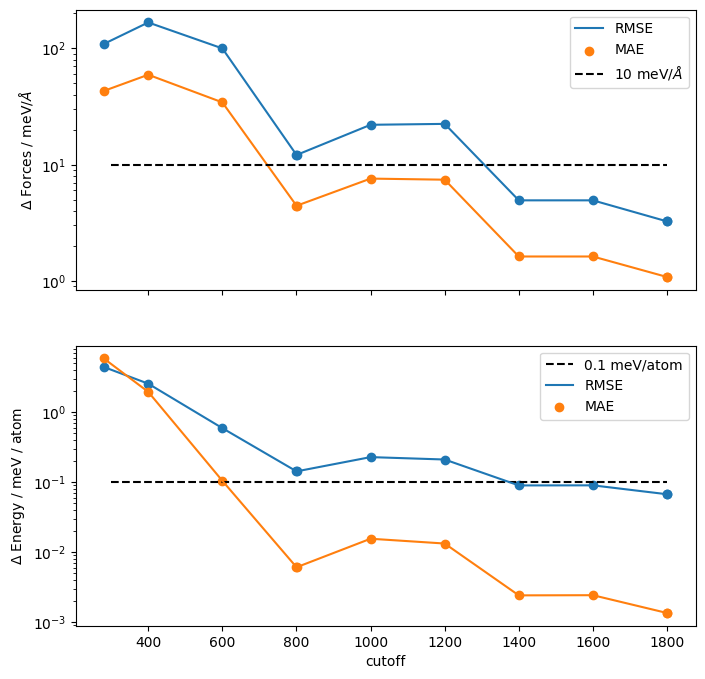

In [7]:
fig, ax = plt.subplots(2, sharex=True, figsize=(8, 8))
ax[0].plot(mses_forces.keys(), mses_forces.values(), label="RMSE")
ax[0].scatter(mses_forces.keys(), mses_forces.values())

ax[0].scatter(maes_forces.keys(), maes_forces.values(), label="MAE")
ax[0].plot(maes_forces.keys(), maes_forces.values())
ax[0].set_yscale("log")
ax[0].set_ylabel(r"$\Delta$ Forces / meV$/\AA$")
ax[0].hlines(10, 300, 1800, color="black", ls="--", label=r"10 meV$/\AA$")
ax[0].legend()

ax[1].set_xlabel("cutoff")
ax[1].set_yscale("log")
ax[1].hlines(0.1, 300, 1800, color="black", ls="--", label=r"0.1 meV/atom")
ax[1].plot(mses_energy.keys(), mses_energy.values(), label="RMSE")
ax[1].scatter(mses_energy.keys(), mses_energy.values())

ax[1].scatter(maes_energy.keys(), maes_energy.values(), label="MAE")
ax[1].plot(maes_energy.keys(), maes_energy.values())
ax[1].legend()
ax[1].set_ylabel(r"$\Delta$ Energy / meV / atom")